# Dependence Modelling between Financial Assets

In this notebook we will examine how to model two financial assets simultaneously. In doing so, we must have a model for each asset's return respectivley, and a method to combine these (univariate) models. We will use the EUR/USD and NOK/USD currencies as our assets. There will be ten years of weekly data, going back to 2011. Since we are modelling returns, we will calculate the log-returns of the assets' price histories. 

The univariate model for each asset will be a no-mean GARCH(1,1) model, described below:
$$
r_t = \sigma_t \xi_t, \quad \xi_t \sim N(0,1)
$$

$$
\sigma_t^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2
$$

The multivariate model between the two assets will be created from a range of copulas. Copulas are multivariate tools (in fact distributions) which may be used to combine multiple univariate distributions into one multivariate distribution. 

Before we create a multivariate model however, we will examine a couple of useful correlation measures.

**_The goal is to be able to model the dependency between the assets. This allows us to e.g. Monte Carlo simulate both assets more accurately._**

---



### Introduction, Data Preparation and Visualization

The data is fetched from Yahoo! Finance again, and similar to before the log returns are calculated.

In [60]:
import numpy as np
from pandas_datareader import data as pdr

# Weekly data
eur_weekly = pdr.get_data_yahoo("EURUSD=X", start="2011-12-28", end="2021-12-28", interval="wk")
eur_weekly = eur_weekly["Adj Close"]
nok_weekly = pdr.get_data_yahoo("NOKUSD=X", start="2011-12-28", end="2021-12-28", interval="wk")
nok_weekly = nok_weekly["Adj Close"]

# Log Returns
eur_weekly_returns = np.log(eur_weekly / eur_weekly.shift(1))[1:]
nok_weekly_returns = np.log(nok_weekly / nok_weekly.shift(1))[1:]

In [64]:
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)

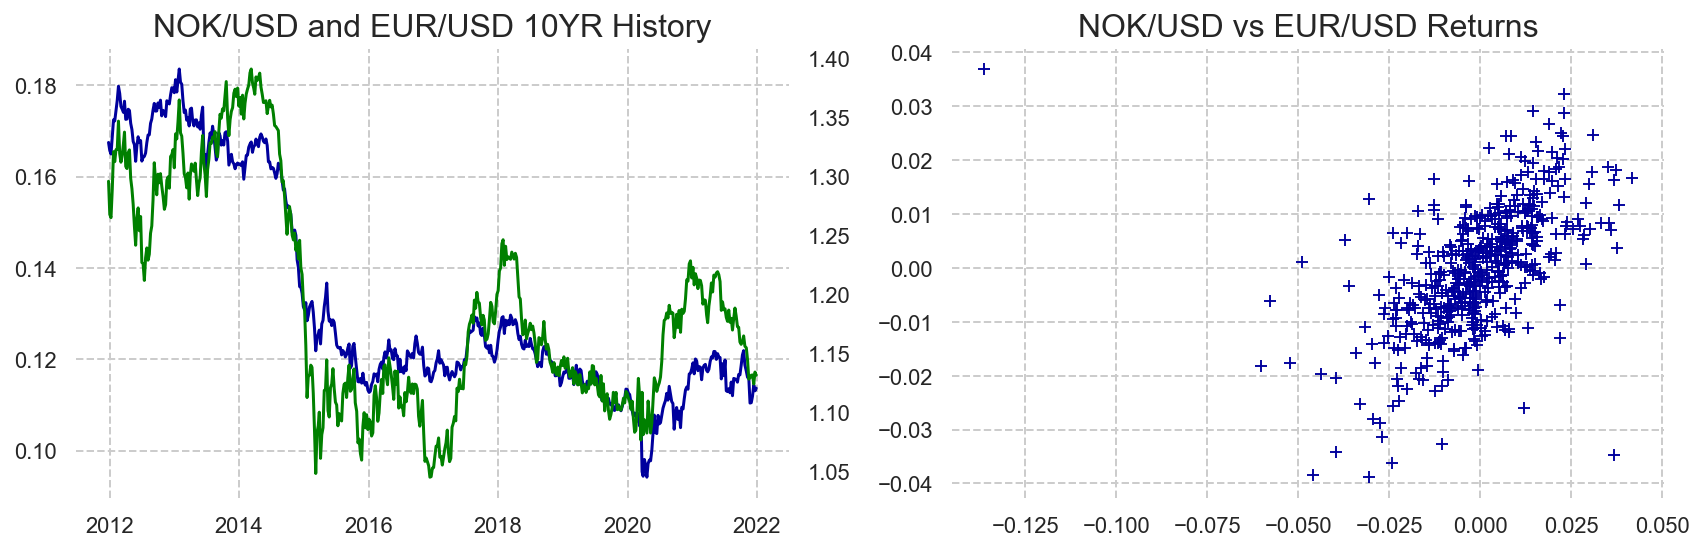

In [700]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(nok_weekly, label='NOK/USD')
ax2 = axs[0].twinx()
ax2.plot(eur_weekly, color='green', label='EUR/USD') 
ax2.grid(False)

axs[0].tick_params(left = False)
ax2.tick_params(right = False)

axs[0].set_frame_on(False)
ax2.set_frame_on(False)
axs[0].set_title('NOK/USD and EUR/USD 10YR History', fontsize=16)


axs[1].scatter(nok_weekly_returns, eur_weekly_returns, marker='+', linewidths=0.95)
axs[1].set_frame_on(False)
axs[1].set_title('NOK/USD vs EUR/USD Returns', fontsize=16)

fig.set_size_inches(12, 4)
plt.tight_layout()
plt.show()

We can visually observe a high correlation between the two assets. This supports the idea that a multivariate model is required to capture both assets' price movements simultaneously. If they were uncorrelated, univariate models would suffice, since the sampling form their distributions would already be independent.

---

### Correlation and Autocorrelation 

In order to quantify the aforementioned correlation we look at three primary correlation measures:

* Pearson's Rho
* Spearman's Rank Correlation
* Kendall's Tau

Each of these measures tries to capture the co-movement of two data sets.

---

### Model for Returns and Volatility for the EUR and NOK

As previously, we model each asset's returns by a no-mean GARCH(1,1) model. This model is described below.

$$ r_t = \sigma_t \xi_t, \quad \xi_t \sim N(0, 1)$$
$$ \sigma_t^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2$$

For each asset we will have to Maximum Likelihood Estimate the parameters of the GARCH(1,1) process, and then examine how well the model fits the data by looking at QQ-plots and ECDF-plots.

In [89]:
fixed_vol_eur = eur_weekly_returns.std()
fixed_vol_nok = nok_weekly_returns.std()

eur_standardized_returns = eur_weekly_returns/fixed_vol_eur
nok_standardized_returns = nok_weekly_returns/fixed_vol_nok

In [88]:
import pandas as pd

columns = ['EUR/USD', 'NOK/USD']
index = eur_standardized_returns.index
data = zip(eur_standardized_returns, nok_standardized_returns)
df = pd.DataFrame(data, columns=columns, index=index)
df

,EUR/USD,NOK/USD
Date,,
2012-01-02,-1.945804,-0.649353
2012-01-09,-0.187321,-0.277780
2012-01-16,1.658069,1.322350
2012-01-23,2.173937,1.384259
2012-01-30,-0.571471,-0.084226
...,...,...
2021-11-29,0.169191,0.046835
2021-12-06,0.018035,0.783095
2021-12-13,-0.608303,1.341017


We can examine how well these follow the normal distribution. 

In [99]:
from scipy import stats

def qq_plot_normal(data, title, ax):
    observations = data
    observations.sort()
    n_observations = len(observations)

    empirical_quantiles = observations
    theoretical_quantiles = [stats.norm.ppf((i - 0.5)/n_observations) for i in range(1, n_observations + 1)]

    ## qq-line (y = mx + b) based on the 25th and 75th quantile of each distribtuion. 
    (x1, x2) = stats.norm.ppf((0.25, 0.75))
    (y1, y2) = np.quantile(observations, (0.25, 0.75))

    slope = (y2 - y1)/(x2 - x1)
    intercept = y2 - (slope * x2)
    qqrange = np.linspace(theoretical_quantiles[0], theoretical_quantiles[-1])
    qqline = [slope * x + intercept for x in qqrange]

    plot = ax.plot(qqrange, qqline, linestyle='dashdot', color='red')
    plot = ax.scatter(theoretical_quantiles, empirical_quantiles, marker='+', linewidths=0.75, zorder=2)
    ax.set_title(title)
    ax.set_frame_on(False)

    return plot

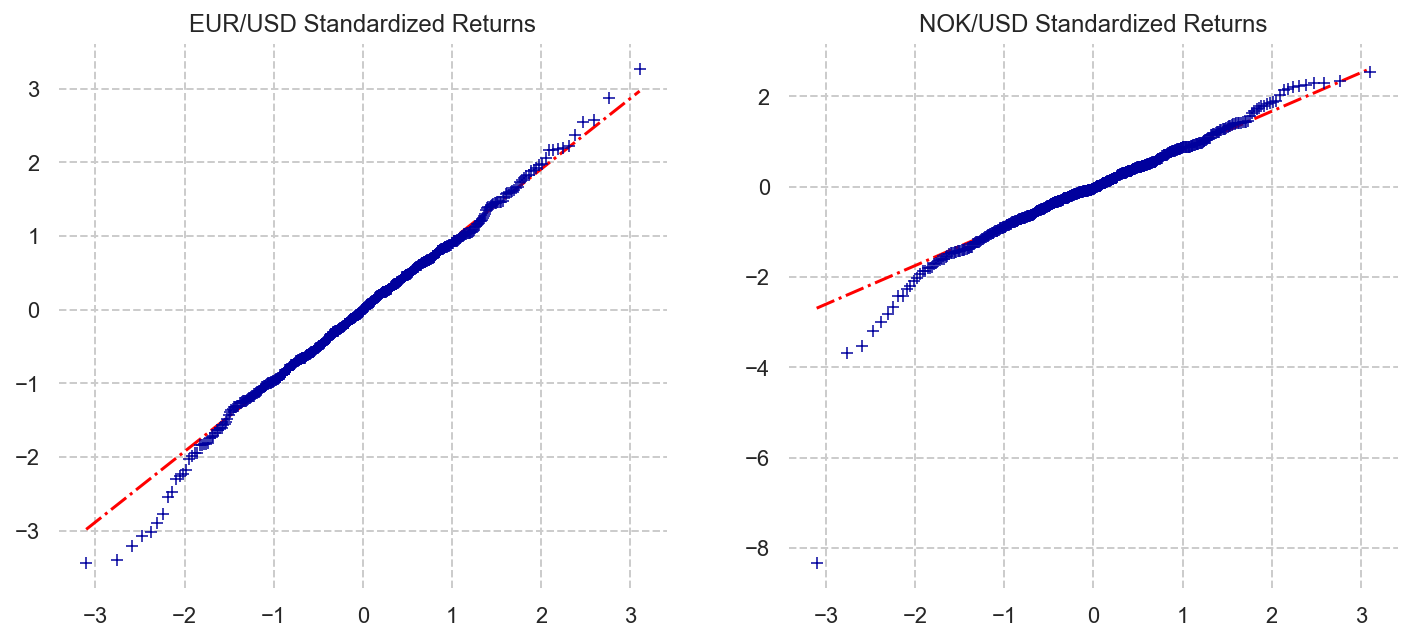

In [102]:
fig, axs = plt.subplots(1, 2)

qq_plot_normal(eur_standardized_returns.to_list(), 'EUR/USD Standardized Returns', axs[0])
qq_plot_normal(nok_standardized_returns.to_list(), 'NOK/USD Standardized Returns', axs[1])

fig.set_size_inches(12, 5)
plt.show()


---

Ok model. Let's fit a copula!

Normal (boring) bivariate copula in canonical representation.

In [676]:
from numpy.linalg import inv

def normal_copula_canonical(u1, u2, corr):
     u = np.array([[u1], 
     [u2]])
     u = stats.norm.ppf(u)
     u_inv = np.transpose(u)

     P = np.array([[1, corr],
     [corr, 1]])
     I = np.array([[1, 0],
     [0, 1]])
     
     return (1/np.sqrt(1-corr ** 2)) * np.exp(-0.5 * ((np.transpose(u) @ (inv(P)- I) @ u)[0][0]))

def copula_implied_pdf(x1, x2, corr):
     u1 = stats.norm.cdf(x1)
     u2 = stats.norm.cdf(x2)

     return normal_copula_canonical(u1, u2, corr) * stats.norm.pdf(x1) * stats.norm.pdf(x2) 

def log_likelihood(param, sample):
     
     likelihood = 0
     for i in range(len(sample[0])):
          u1 = sample[0][i]
          u2 = sample[1][i]
          likelihood = likelihood - np.log(normal_copula_canonical(u1, u2, param[0]))

     return likelihood

Let's transform our sample into uniform vairables, which will be used to fit the copula.

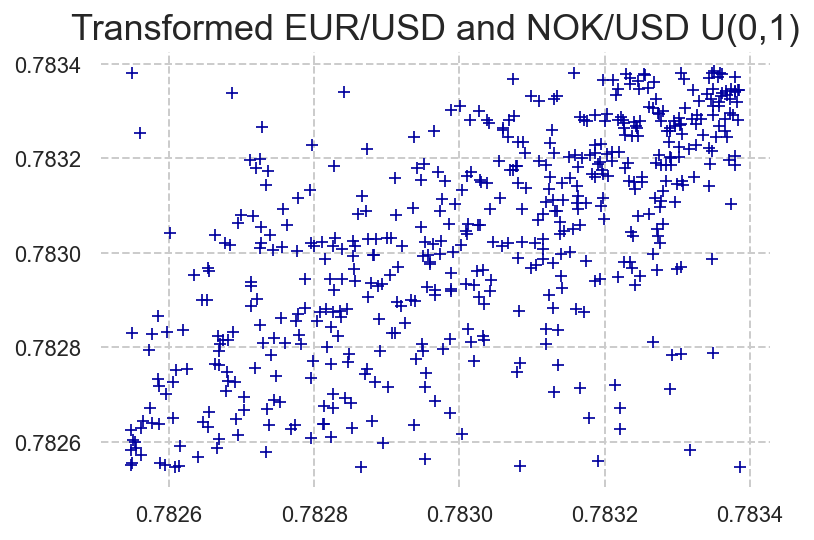

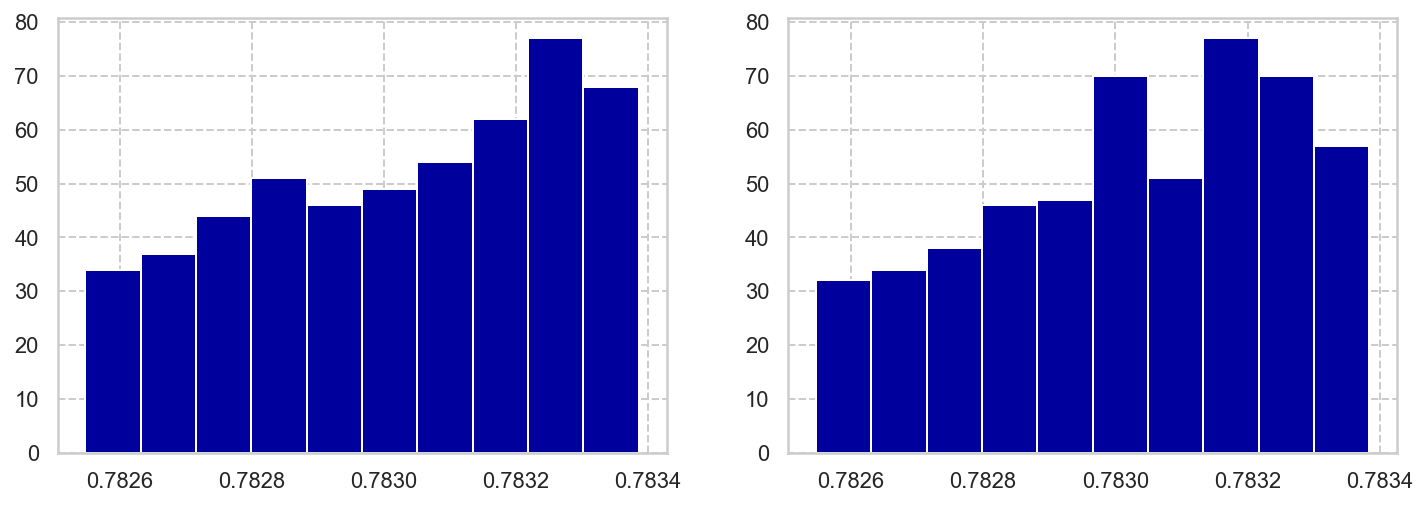

In [573]:
df_uniform = df
df_uniform['EUR/USD'] = df_uniform['EUR/USD'].apply(stats.norm.cdf)
df_uniform['NOK/USD'] = df_uniform['NOK/USD'].apply(stats.norm.cdf)

plt.scatter(df_uniform['EUR/USD'].apply(stats.norm.cdf), 
            df_uniform['NOK/USD'].apply(stats.norm.cdf), 
            marker='+', 
            linewidths=0.85)
plt.title('Transformed EUR/USD and NOK/USD U(0,1)', fontsize=18)
plt.box(False)
plt.show()

fig, axs = plt.subplots(1, 2)
axs[0].hist(df_uniform['EUR/USD'].apply(stats.norm.cdf))
axs[1].hist(df_uniform['NOK/USD'].apply(stats.norm.cdf))
fig.set_size_inches(12, 4)
plt.show()

df_uniform.to_excel('test.xlsx')

In [611]:
from scipy.optimize import minimize

cons_ewma = [{'type': 'ineq', 'fun': lambda x: x[0]},
             {'type': 'ineq', 'fun': lambda x: 1 - x[0]}]


sampleu1 = df_uniform['EUR/USD'].apply(stats.norm.cdf).to_list()
sampleu2 = df_uniform['NOK/USD'].apply(stats.norm.cdf).to_list()
sample = [sampleu1, sampleu2]


x0 = [0.73]
r = minimize(log_likelihood, x0, args=sample, constraints=cons_ewma)
r.x
r

     fun: -2129.499925903377
     jac: array([-988918.4480896])
 message: 'Optimization terminated successfully'
    nfev: 17
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.99973631])

In [234]:
x, y = eur_standardized_returns.to_list(), nok_standardized_returns.to_list()
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))
print(stats.kendalltau(x, y))

(0.5308025410988917, 2.8064388956790167e-39)
SpearmanrResult(correlation=0.6545491122276489, pvalue=3.663010524697217e-65)
KendalltauResult(correlation=0.4810010222016311, pvalue=1.180453551969619e-60)


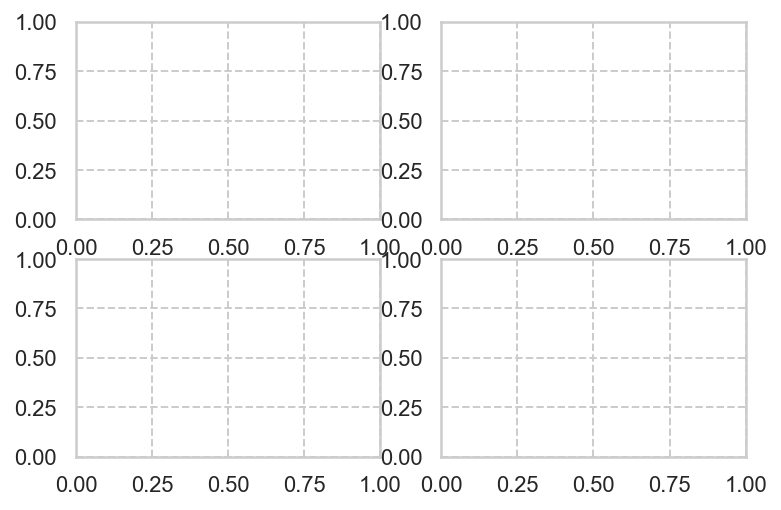

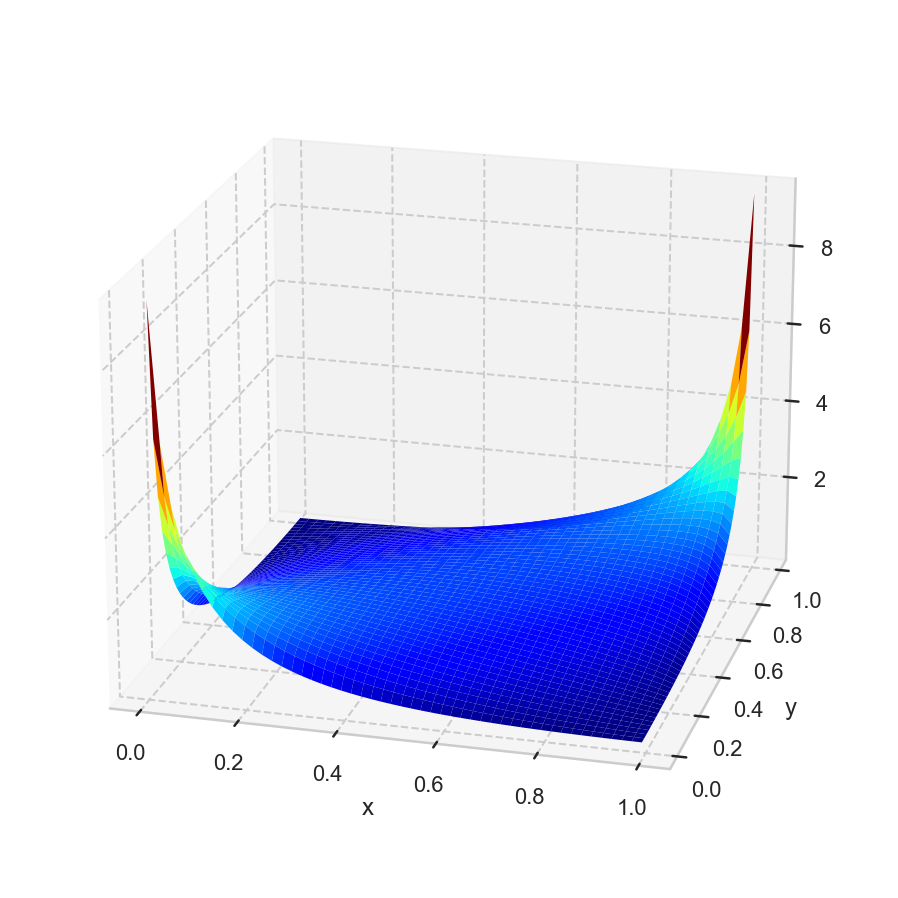

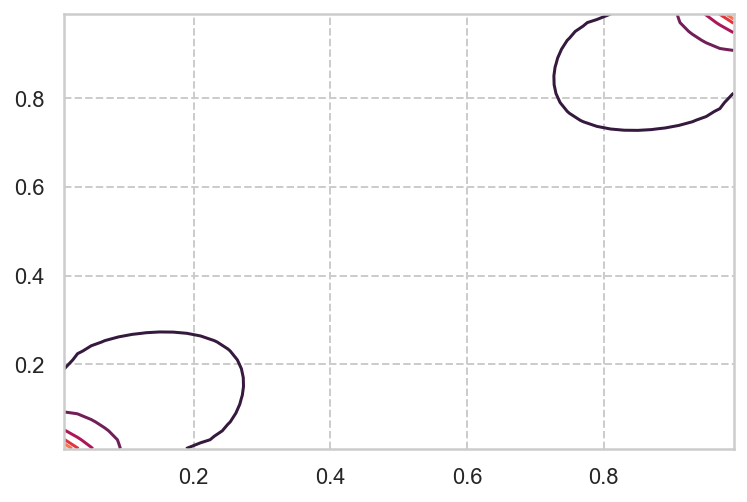

In [705]:
fig, axs = plt.subplots(2, 2)

X = np.linspace(0.01, 0.99)
Y = np.linspace(0.01, 0.99)
Z = []
for i in range(len(X)):
    u1 = X[i]
    inner = []
    for j in range(len(Y)):
        u2 = Y[j]
        inner.append(normal_copula_canonical(u1, u2, 0.6))
    Z.append(inner)

X, Y = np.meshgrid(X, Y)
Z = np.array(Z)
fig = plt.figure()
axs[0, 0] = plt.axes(projection='3d')
axs[0, 0].plot_surface(X, Y, Z , cmap='jet', edgecolor='none')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
fig.set_size_inches(8, 8)
axs[0, 0].view_init(20, -75)
plt.show()

plt.contour(X, Y, Z)
plt.show()

We want to change to a GARCH(1,1) model instead.

In [385]:
def log_likelihood_garch(param, data):
    # param[0] is omega
    # param[1] is alpha
    # param[2] is beta
    log_likelihood = 0
    vol_est = param[0] + param[1] * (data[1] ** 2) + param[2] * (data[1] ** 2)
    n_observations = len(data)

    for i in range(2, n_observations):
        log_likelihood = log_likelihood + (np.log(vol_est) + (data[i] ** 2) / vol_est)
        vol_est = param[0] + param[1] * (data[i] ** 2) + param[2] * vol_est
        
    return log_likelihood

In [536]:
cons_garch = [{'type': 'ineq', 'fun': lambda x:  -x[1] - x[2] + 1},
        {'type': 'ineq', 'fun': lambda x:  x[0]},
        {'type': 'ineq', 'fun': lambda x:  x[1]},
        {'type': 'ineq', 'fun': lambda x:  x[2]}]

x0 = [0.0002, 0.2, 0.6]      
result_eur_garch = minimize(log_likelihood_garch, x0, constraints = cons_garch, args=eur_weekly_returns)

x0 = [0.1, 0.3, 0.7]
result_nok_garch = minimize(log_likelihood_garch, x0, constraints = cons_garch, args=nok_weekly_returns)

print(result_eur_garch.x)
print(result_nok_garch.x)

[2.e-04 2.e-01 6.e-01]
[7.86445141e-05 2.56152819e-01 4.63408961e-01]


In [537]:
def GARCH_annualized(data, omega, alpha, beta, measurement_time):
    n_observations = len(data)
    vol_est = np.sqrt(omega + alpha * (data[0] ** 2) + beta * (data[0] ** 2))
    vol = []
    for i in range(1, n_observations):
        vol.append(vol_est)
        vol_est = np.sqrt(omega + alpha * (data[i] ** 2) + beta * (vol_est ** 2))
    vol_annual = [x * np.sqrt(1/measurement_time) for x in vol]
    return vol_annual

In [538]:
eur_garch = GARCH_annualized(eur_weekly_returns, result_eur_garch.x[0], result_eur_garch.x[1], result_eur_garch.x[2], 1/52)
nok_garch = GARCH_annualized(nok_weekly_returns, result_nok_garch.x[0], result_nok_garch.x[1], result_nok_garch.x[2], 1/52)
eur_sample = eur_weekly_returns[1:]/eur_garch
nok_sample = nok_weekly_returns[1:]/nok_garch

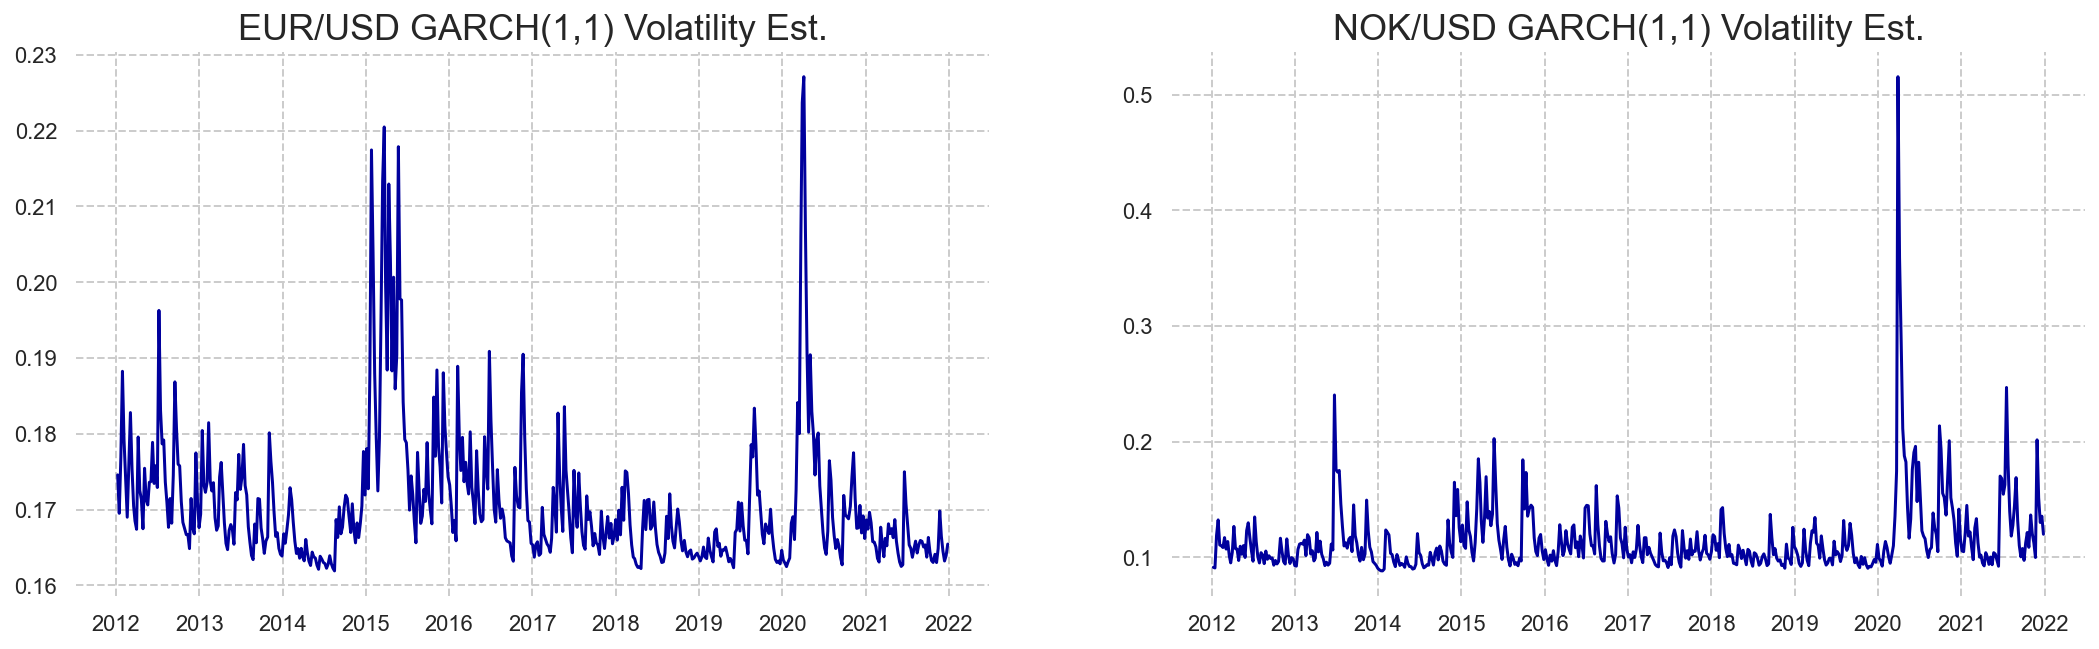

In [539]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(eur_weekly_returns.index[1:], eur_garch)
axs[1].plot(nok_weekly_returns.index[1:], nok_garch)

axs[0].set_frame_on(False)
axs[1].set_frame_on(False)

axs[0].set_title('EUR/USD GARCH(1,1) Volatility Est.', fontsize=18)
axs[1].set_title('NOK/USD GARCH(1,1) Volatility Est.', fontsize=18)

fig.set_size_inches(18, 5)
plt.show()

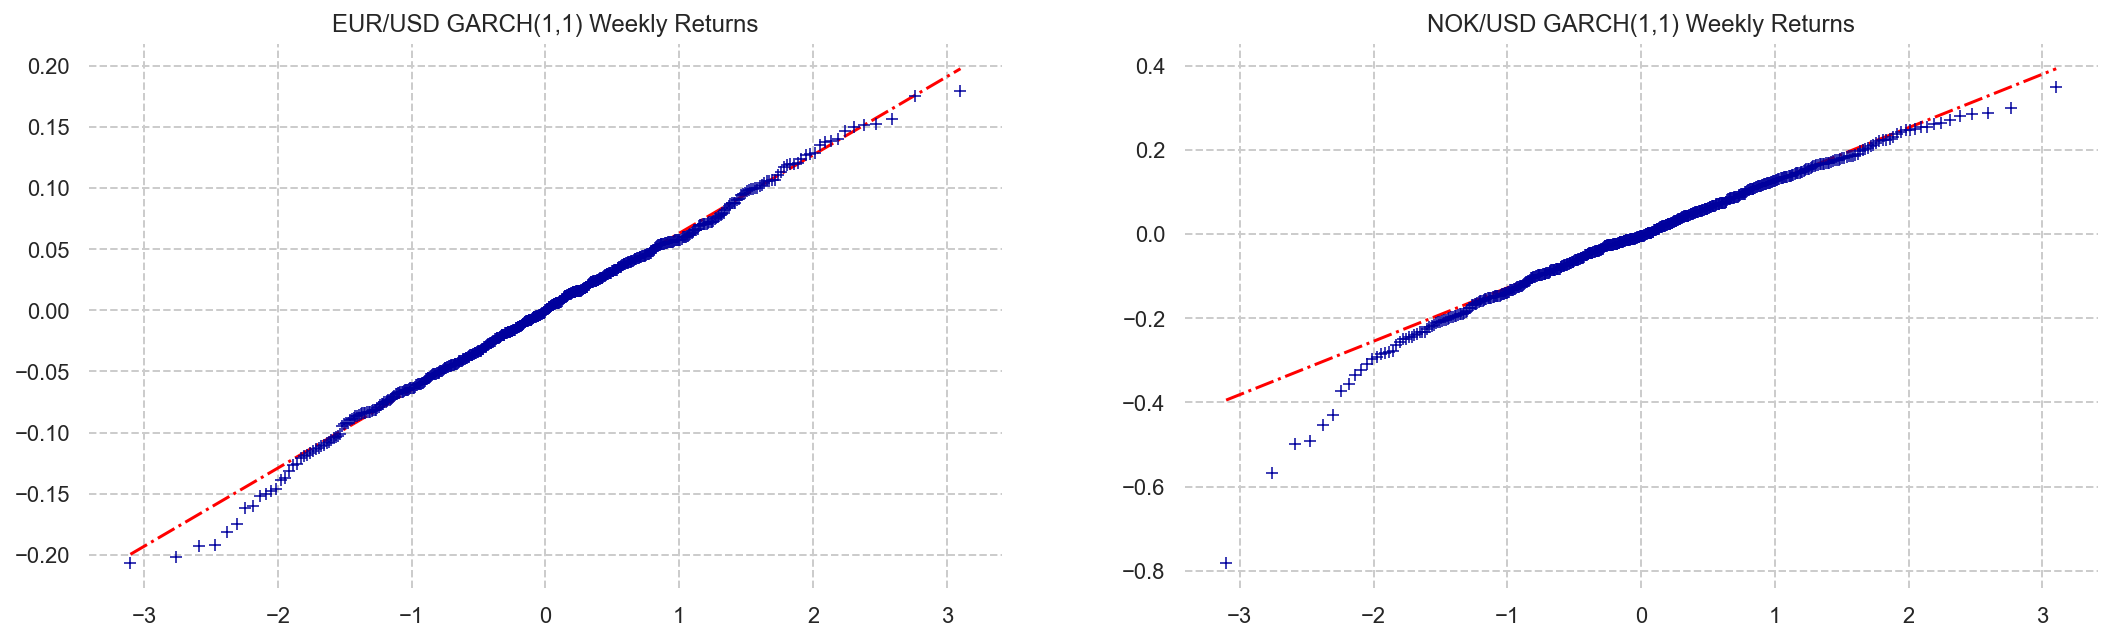

In [540]:
fig, axs = plt.subplots(1, 2)

qq_plot_normal(eur_sample.to_list(), 'EUR/USD GARCH(1,1) Weekly Returns', axs[0])
qq_plot_normal(nok_sample.to_list(), 'NOK/USD GARCH(1,1) Weekly Returns', axs[1])

fig.set_size_inches(18, 5)
plt.show()

In [554]:
u1_eur_garch = eur_sample.apply(stats.norm.cdf).to_list()
u2_nok_garch = nok_sample.apply(stats.norm.cdf).to_list()

In [560]:
cons = [{'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: 1 - x[0]}]

sample = [u1_eur_garch, u2_nok_garch]

x0 = [0.23]
r = minimize(log_likelihood, x0, args=sample, constraints=cons)
r.x
r

/var/folders/d7/rpl_88f12ln2z1s2h4m9ybjm0000gn/T/ipykernel_13302/350714488.py:14: RuntimeWarning: invalid value encountered in sqrt
  return (1/np.sqrt(1-corr ** 2)) * np.exp(-0.5 * ((np.transpose(u) @ (inv(P)- I) @ u)[0][0]))
/var/folders/d7/rpl_88f12ln2z1s2h4m9ybjm0000gn/T/ipykernel_13302/350714488.py:14: RuntimeWarning: overflow encountered in exp
  return (1/np.sqrt(1-corr ** 2)) * np.exp(-0.5 * ((np.transpose(u) @ (inv(P)- I) @ u)[0][0]))


     fun: -2955.5282829671273
     jac: array([-96490.40817261])
 message: 'Optimization terminated successfully'
    nfev: 16
     nit: 10
    njev: 6
  status: 0
 success: True
       x: array([0.98895554])

In [647]:
u1_samp = df_uniform['EUR/USD'].to_list()
u2_samp = df_uniform['NOK/USD'].to_list()
print(u1_samp[0], u2_samp[0])
print(u1_samp[1], u2_samp[1])
print(u1_samp[2], u2_samp[2])

u_samp = [u1_samp, u2_samp]
print('========================')

print(u_samp[0][0], u_samp[1][0])
print(u_samp[0][1], u_samp[1][1])
print(u_samp[0][2], u_samp[1][2])

0.7809260807433658 0.781779731944889
0.7823265007379787 0.7822174064935625
0.783597088515608 0.7835154708863602
0.7809260807433658 0.781779731944889
0.7823265007379787 0.7822174064935625
0.783597088515608 0.7835154708863602


Implement Gaussian Copula. Correct MATLAB answer 0.6518

In [648]:
def log_likelihood_normal_copula(param, sample):
    likelihood = 0
    for i in range(len(sample[1])):
        u1 = sample[0][i]
        u2 = sample[1][i]
        likelihood = likelihood + np.log(normal_copula_canonical(u1, u2, param[0]))
    
    return -likelihood

In [649]:
normal_copula_canonical(0.1, 0.1, 0.5)
normal_copula_canonical(0.6, 0.7, 0.35)

1.0992794252734586

In [669]:
cons = [{'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: 1 - x[0]}]

sample = [u1_eur_garch, u2_nok_garch]

x0 = [0.99999]
r = minimize(log_likelihood_normal_copula, x0, args=u_samp, constraints=cons)
r.x
r

     fun: -2915.5195660282934
     jac: array([-19366158.70849609])
 message: 'Optimization terminated successfully'
    nfev: 2
     nit: 5
    njev: 1
  status: 0
 success: True
       x: array([0.99999])

[]

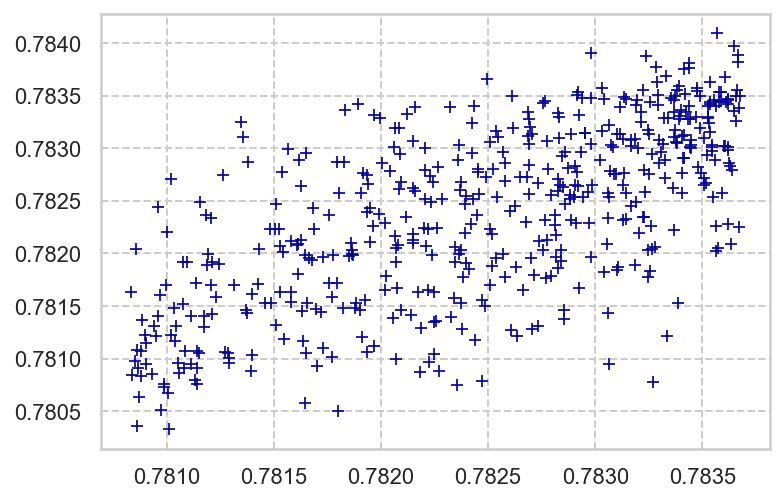

In [708]:
from copulas.multivariate import GaussianMultivariate

copula = GaussianMultivariate()
copula.fit(df_uniform)
copula.covariance
z = copula.sample(500)
plt.scatter(z['EUR/USD'], z['NOK/USD'], marker='+', linewidths=0.85)
plt.plot()       

[]

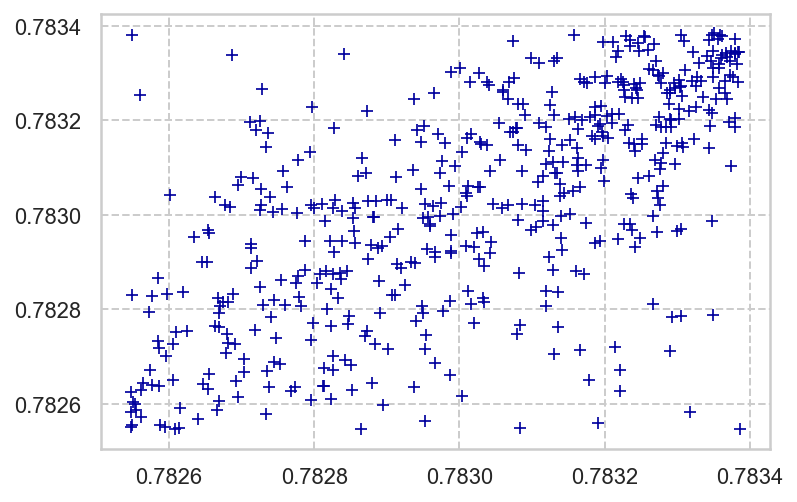

In [709]:
plt.scatter(df_uniform['EUR/USD'].apply(stats.norm.cdf), 
            df_uniform['NOK/USD'].apply(stats.norm.cdf), 
            marker='+', 
            linewidths=0.85)
plt.plot()     

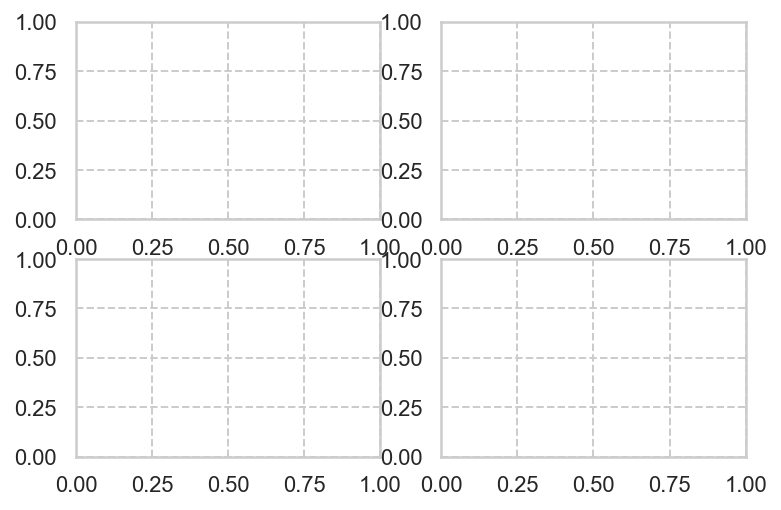

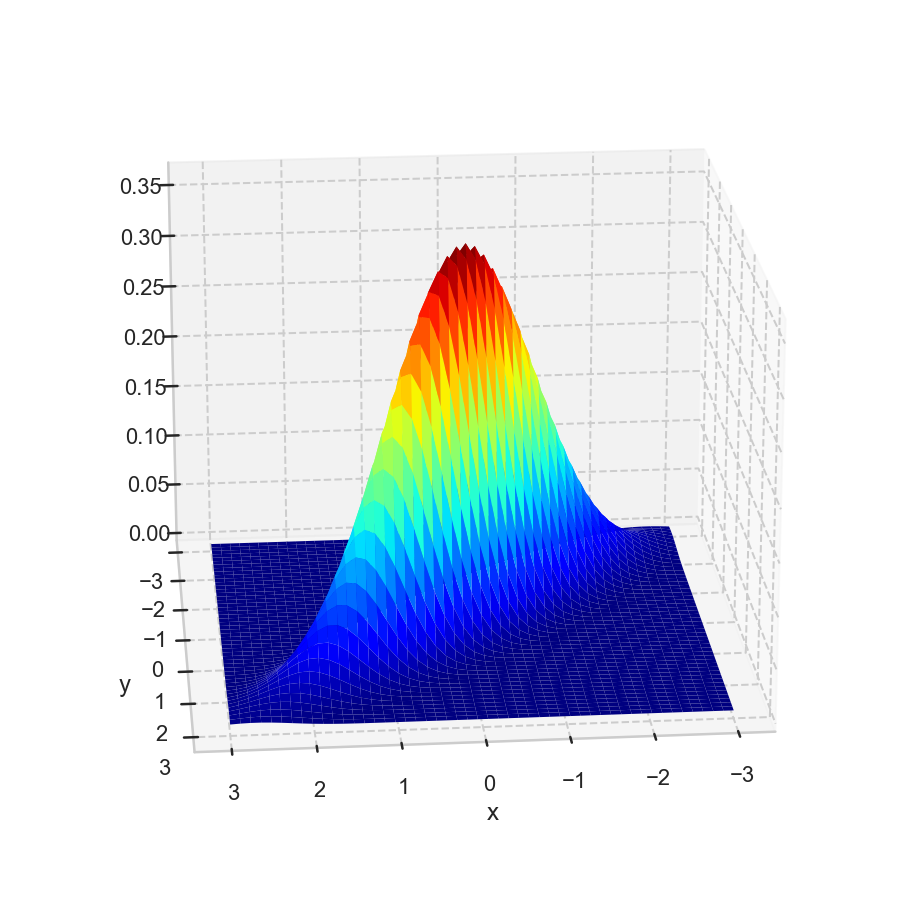

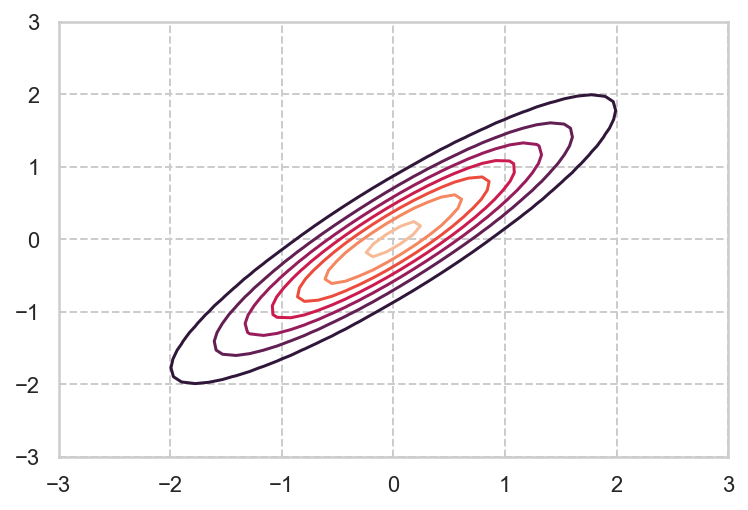

In [679]:
fig, axs = plt.subplots(2, 2)

X = np.linspace(-3, 3)
Y = np.linspace(-3, 3)
Z = []
for i in range(len(X)):
    u1 = X[i]
    inner = []
    for j in range(len(Y)):
        u2 = Y[j]
        inner.append(copula_implied_pdf(u1, u2, 0.9))
    Z.append(inner)

X, Y = np.meshgrid(X, Y)
Z = np.array(Z)
fig = plt.figure()
axs[0, 0] = plt.axes(projection='3d')
axs[0, 0].plot_surface(X, Y, Z , cmap='jet', edgecolor='none')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
fig.set_size_inches(8, 8)
axs[0, 0].view_init(20, 85)
plt.show()

plt.contour(X, Y, Z)
plt.show()